This code aims to computationally study the statistics of risk in order to develop better strategies and beat the brothers at the game. Before beginning a computational study, it is advantegeous to develop the mathematical theory. 

In a classical risk offensive, an attacking army attempts to annhilate a defending army through a series of dice rolls which affect updates to the number of live armsmen on the attacking and defending sides. Thus any risk battle can be represented as a set ordered by the integers of the number of armsmen belonging to each side at each discrete iteration step. Define $H = \{ (M_{A,i}, M_{D,i}): i \in [1,T] \}$ where $i$ is an integer, $H$ is a battle history, $M_{A,i}, M{D,i}$ are the number of armsmen belonging to the attacker and defender respectively at each discrete step in the battle. 

To develop a theory of strategy we must first investigate the probabalistic dynamics of a battle. Specifically, we will begin by studying the distribution over outcomes when an attacker and defender both use only a single die. 

Let $d_A$ and $d_D$ be realizations of the attacking and defending dice, whose distributions are uniform over the integers $1$ through $6$. $\mathcal{P}(d_A) = \mathcal{P}(d_D) = \frac{1}{6}$. The defender is said to win if $d>=a$. This amounts to $$\frac{1}{2}\sum\limits_{n=1}^6 n = \frac{6^2 + 6}{2} = 21$$ outcomes of a total of $6^2$ outcomes. Thus the probability of the defender winning $p_D = \mathcal{P}(d \ge a) = \frac{21}{36} \approx .58$. Then $p_A = 1-p_d = .42$

It should seem that defender has the probabalistic advantage. However, the probabalistic dynamics become far more interesting when a multiplicity of dice are used by the attacker and defender. In fact, the dice configuration has far more impact on the resulting probabality distributions than does the decision rule for the outcome of a single dice comparison. Suppose $n_A = 3$ dice are used by the attacker and $n_D = 2$ dice are used by the defender. We are interested in deriving distribution over the number of losses for the attacker and the defender. Note that the total number of outcomes in this situation $$T(n_A, n_D) = (6^{n_A})\times(6^{n_D}) = 7776$$. 

Now, let the losses for attacker $A$ and defender $D$ be denoted by $l_A, l_D$ respectively. There is a bijection between loses for $A$ and for $D$, so it is only necessary to consider one side, either that of the attacker or of the defender. 

1. $\mathcal{P}(l_A = 1) = \mathcal{P}(l_D = 1)$
2. $\mathcal{P}(l_A = 2) = \mathcal{P}(l_D = 0)$
3. $\mathcal{P}(l_A = 0) = \mathcal{P}(l_D = 2)$

(2) can be restated as asking for the probability all of the attacking dice are larger than all of the defending dice. 

$$\mathcal{P}(\ \min d_A > \max d_D) = \frac{3!2!}{T}\sum\limits^6_{i=1}\sum^i_{j=1}\left(j-1\right)^3 $$




In particular, when a die of an attacker and defender are compared, if the value of the defending die is greater than or equal to the value of the attacking die then the attacker 



In [132]:
def ran(n):
    return range(1,n+1)

def isall(func, arr):
    return sum(map(func, arr)) > 0

def isgreater(val):
    return lambda x: x>val

def isless(val):
    return lambda x: x<val

In [160]:
w = 0
for i in ran(6):
    for j in ran(i):
        w+=(j-1)**3
T = 7776
w/T

0.04771090534979424

## Case 3: Attacker Loses 0, Defender Loses 2

In [133]:
from __future__ import division
n3 = 0
T = 7776
for i in ran(6):
    for j in ran(6):
        for k in ran(6):
            for l in ran(6):
                for w in ran(6):
                    if min([i,j,k]) > max([l,w]): n3+=1
p3 = n3/T
p3

0.06648662551440329

In [134]:
range(6-2)

[0, 1, 2, 3]

## Case 2: Attacker Loses 2, Defender Loses 0

In [135]:
n2=0
T = 7776
for i in ran(6):
    for j in ran(6):
        for k in ran(6):
            for l in ran(6):
                for w in ran(6):
                    if max([i,j,k]) <= min([l,w]): n2+=1
p2 = n2/T
p2

0.15213477366255143

## Case 1: Attacker Loses 1, Defender Loses 1

In [136]:
p1 = 1-p2-p3
p1

0.7813786008230452

## Expected Loss of Attacker

In [137]:
xs = np.array([0,1,2])*(-1)
ps = np.array([p3, p1, p2])
mu = (xs*ps).sum()
mu

-1.0856481481481481

## Expected Loss of Defender

In [138]:
xs = np.array([0,1,2])*(-1)
ps = np.array([p2, p1, p3])
mu = (xs*ps).sum()
mu

-0.91435185185185186


First we'll setup a dice class to abstract the dice rolling

In [144]:
import random
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

class Dice:
    def __init__(self, dicemax, ndice):
        self.dicemax = dicemax
        self.ndice = ndice
        self.initial_ndice = ndice
        self.inital_dicemax = dicemax

    def roll(self):
        dice = []
        for i in range(self.ndice):
            dice.append(random.randint(1,self.dicemax))
        return sorted(dice, reverse=True)

    def reset(self):
        self.ndice = self.initial_ndice
        self.dicemax = self.inital_dicemax

Next, a player class to abstract the logic of the attacker and defender

In [145]:
class Player:
    # Then players can subclass to implement different strategies
    def __init__(self, dice, number_of_people):
        self.dice = dice
        self.npeople = number_of_people
        self.initial_people = number_of_people

    def roll(self):
        return self.dice.roll()

    def ready(self, opponent):
        return True

    def reset(self):
        self.npeople = self.initial_people
        self.dice.reset()

class Attacker(Player):
    def roll(self):
        if self.npeople in [3,2]:
            self.dice.ndice=2
        if self.npeople ==1:
            self.dice.ndice=1
        return Player.roll(self)

    def ready(self, opponent):
        return self.npeople > 1

class Defender(Player):
    def ready(self, opponent):
        return self.npeople > 0


Finally, an interface to simulating a face off between two armies, here dubbed an *offensive*:

In [146]:
class Offensive:
    def __init__(self, attacker, defender, toprint=False):
        self.a = attacker
        self.d = defender
        self.toprint = toprint
        self.niter = 0
        self.menA = []
        self.menD = []

    def extension(self,rollA, rollD):
        return np.array([0,0])

    def compareDice(self, diceA, diceD):
        if diceA > diceD:
            return (0,-1)
        elif diceA <= diceD:
            return (-1,0)

    def standardBattleContract(self, rolla, rolld):
        minind = min(len(rolla), len(rolld))
        aligneda = rolla[:minind]
        alignedd = rolld[:minind]
        contract = map(
            lambda x: self.compareDice(*x),
            zip(aligneda, alignedd))
        lossA = 0
        lossD = 0
        for c in contract:
            lossA += c[0]
            lossD += c[1]
        return np.array([lossA, lossD])

    def show(self, loss, rolla, rolld):
        lossA, lossD = loss
        print "Dice: "
        print "A: {}".format(rolla)
        print "D: {}".format(rolld)
        print "   +++   "
        print "Loss: "
        print "A: {}".format(lossA)
        print "B: {}".format(lossD)
        print "   +++   "
        print "Men:"
        print "A: {}".format(self.a.npeople)
        print "D: {}".format(self.d.npeople)
        print "------------------"

    def didWin(self):
        return self.d.npeople==0

    def canIterate(self):
        can= self.a.ready(self.d) and self.d.ready(self.a)
        return can

    def iterate(self):
        rolld = self.d.roll()
        rolla = self.a.roll()
        loss = self.extension(rolla, rolld) \
                + self.standardBattleContract(rolla, rolld)
        self.a.npeople += loss[0]
        self.d.npeople += loss[1]
        if self.toprint:
            self.show(loss, rolla,rolld)
        self.menA.append(self.a.npeople)
        self.menD.append(self.d.npeople)
        self.niter+=1

    def reset(self):
        self.a.reset()
        self.d.reset()
        self.niter = 0
        self.menA = []
        self.menD = []

    def simulate(self):
        while self.canIterate():
            self.iterate()

        return self.a.npeople, self.d.npeople

We invented some custom rules in my house, so we'll add them here

In [147]:
class LipshitzianOffensive(Offensive):
    def extension(self, rollA, rollD):
        allgreater = min(rollD) >= max(rollA)
        if allgreater:
            return np.array([-1,0])
        else:
            return np.array([0,0])

Finally we can simulate

In [148]:
T = 100
battle = LipshitzianOffensive(
    Attacker(Dice(6,3), 70),
    Defender(Dice(6,2), 60),
    toprint=False)

resA = []
resD = []
histA = []
histD = []
for i in range(T):
    ra, rd = battle.simulate()
    histA.append(battle.menA)
    histD.append(battle.menD)
    resA.append(ra)
    resD.append(rd)
    battle.reset()

In [149]:
histmatA = np.zeros((T, max(map(len, histA)) ))*np.nan
histmatD = np.zeros((T, max(map(len, histD)) ))*np.nan
for i in xrange(T):
    histmatA[i,:len(histA[i])] = histA[i]
    histmatD[i, :len(histD[i])] = histD[i]
histmatA = ma.array(histmatA, mask=np.isnan(histmatA))
histmatD = ma.array(histmatD, mask=np.isnan(histmatD))

muA = ma.mean(histmatA, axis=0)
muD = ma.mean(histmatD, axis=0)
sigmaA = ma.std(histmatA, axis=0)
sigmaD = ma.std(histmatD, axis=0)
t = np.arange(muA.shape[0])

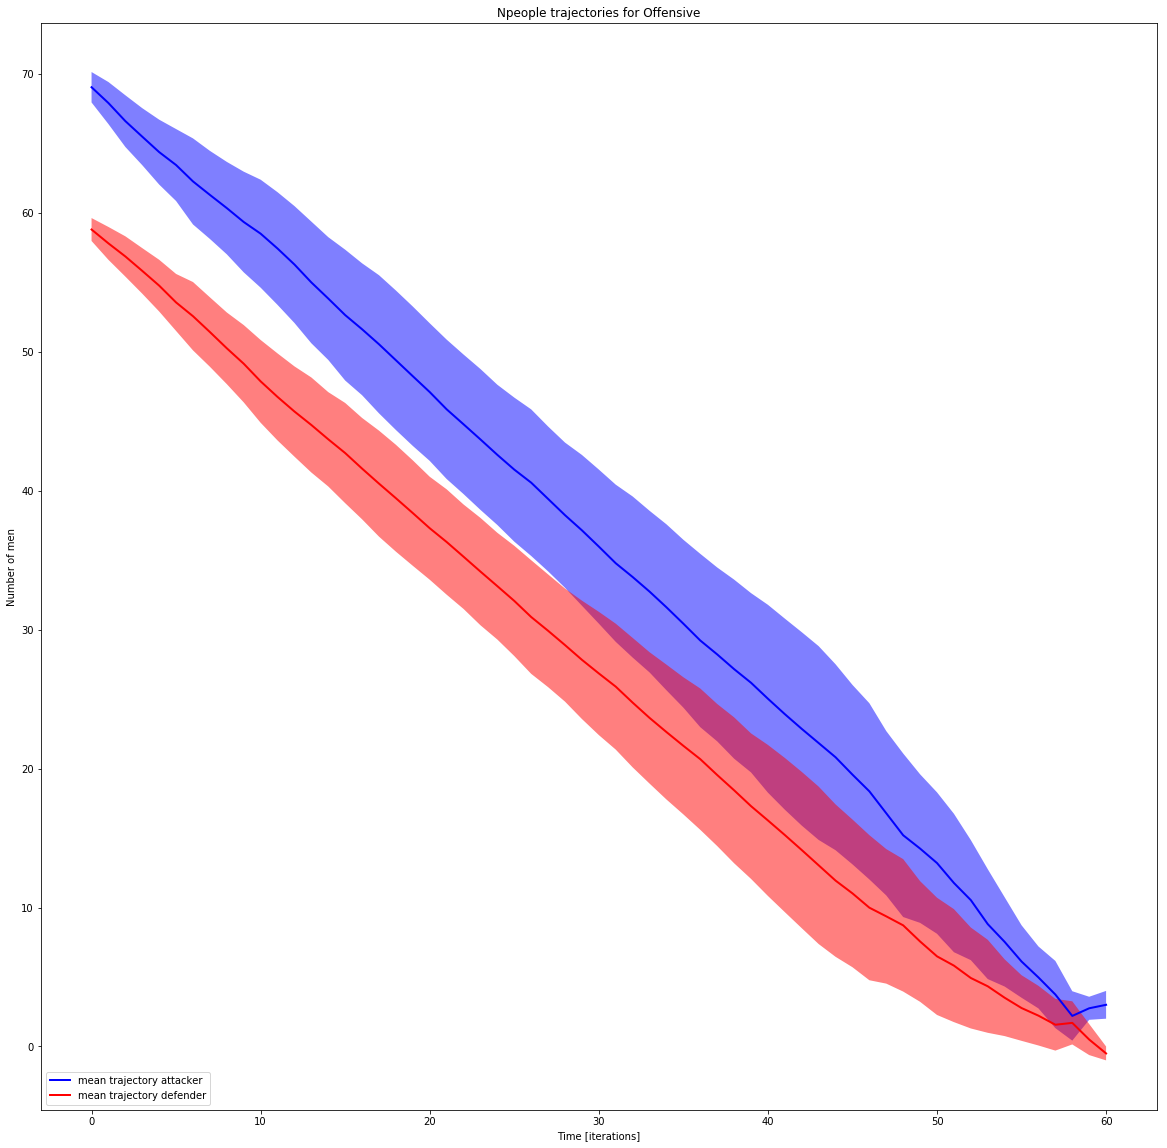

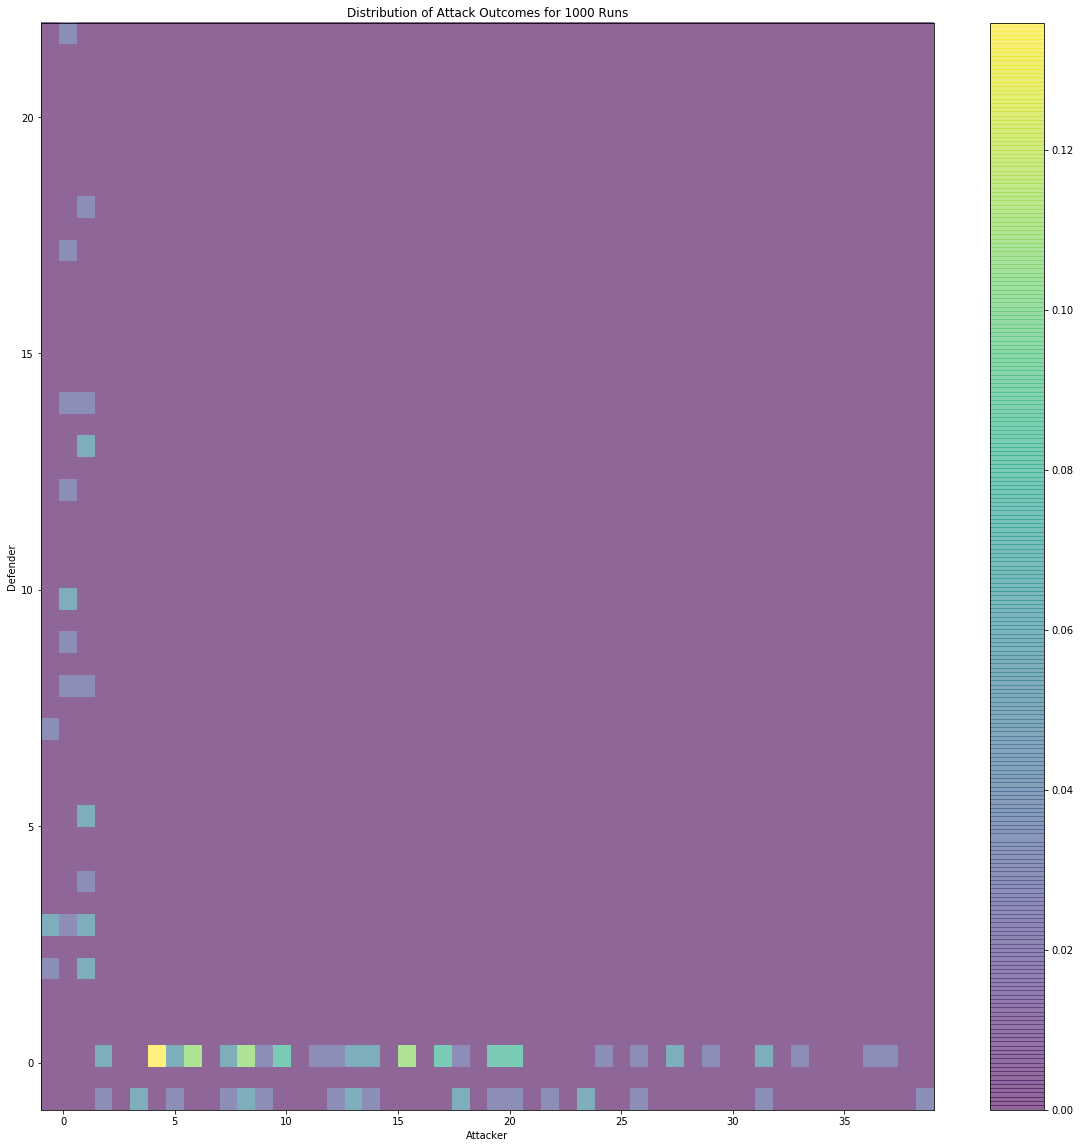

In [152]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pointWin = np.argwhere(muD==0)
fig, ax = plt.subplots(1, figsize=(20,20))
ax.plot(t, muA, lw=2, label='mean trajectory attacker', color='blue')
ax.plot(t, muD, lw=2, label='mean trajectory defender', color='red')
ax.fill_between(t, muA+sigmaA, muA-sigmaA, facecolor='blue', alpha=0.5)
ax.fill_between(t, muD+sigmaD, muD-sigmaD, facecolor='red', alpha=0.5)

ax.set_title("Npeople trajectories for Offensive")
ax.legend(loc='lower left')
ax.set_xlabel("Time [iterations]")
ax.set_ylabel("Number of men")
plt.savefig("./npeople_trajectories.png")
resA = np.array(resA)
resD = np.array(resD)

plt.figure(figsize=(20,20))
plt.hist2d(resA, resD, alpha=.6, normed=True, bins=[50,50])
plt.colorbar()
plt.ylabel("Defender")
plt.title("Distribution of Attack Outcomes for 1000 Runs")
plt.xlabel("Attacker")
plt.savefig("./results.png")

In [16]:
import networkx as nx

In [17]:
class Board(nx.Graph):
    def edge(a, b):
        self.add_edge(a,b)
        return self
board = Board()

In [18]:
Map = {
    "North America":[
        "Alaska",
        "Northwestern Territory",
        "Alberta",
        "Ontario",
        "Eastern Canada",
        "Western United States",
        "Eastern United States",
        "Central America",
        "Greenland"],
    "South America":[
        "Venezuela",
        "Brazil",
        "Peru",
        "Argentina"],
    "Europe":[
        "Iceland",
        "Great Britain",
        "Western Europe",
        "Scandinavia",
        "Northern Europe",
        "Southern Europe",
        "Russia"],
    "Africa":[
        "North Africa",
        "Egypt",
        "East Africa",
        "Central Africa",
        "South Africa",
        "Madagascar"],
    "Asia":[
        "Ural",
        "Afghanistan",
        "Middle East",
        "India",
        "Southern Asia",
        "China",
        "Mongolia",
        "Irkutsk",
        "Siberia",
        "Yakutsk",
        "Kamachatka",
        "Japan"],
    "Australia":[
        "Indonesia",
        "New Guinea",
        "Western Australia",
        "Eastern Australia"
        ]
}

In [4]:
for k, v in Map.iteritems():
    print "{}: {} countries".format(k,len(v))
    map(board.add_node, v)

Europe: 7 countries
Australia: 4 countries
Africa: 6 countries
Asia: 12 countries
North America: 9 countries
South America: 4 countries
